# **Main Objective**

The main objective is to practice knowledge of Data Analysis, Machine Learning and Statistics, using specifically time data. For this, a Business Process Intelligence (BPI) data set was selected.

# **About Dataset**

The dataset was found on the [website](https://www.win.tue.nl/bpi/doku.php?id=2017:challenge) of the 13th International Business Process Intelligence Workshop 2017.

The logs refer to a loan application process of a Dutch financial institute. The data includes all the loan process logs including offers made by the company for accepted loan applications.

For more information about the data, you can consult the [event page](https://www.win.tue.nl/bpi/doku.php?id=2017:challenge) in the 'The Data' section or directly in the [page](https://data.4tu.nl/articles/BPI_Challenge_2017/12696884) of the dataset.

# **Analyzes and predictions**


Some questions that can answer possible problems in the process:

*Question 1:How many applications are created per week?*

*Question 2: What is the total number of successful applications per week?*

*Question 3: Per week, what is the average number of events that occurred until the application was successfully completed?*

*Question 4: How long (in weeks) did each application last that was successfully completed?*

*Question 5: Will the application be finalized this week?*

# **Importing Libraries**

In [56]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import  StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn import metrics

# **Loading Data**

In [57]:
bpi_challenge_2017_data = pd.read_csv('../input/bpichallenge2017/BPI_Challenge_2017.csv') 

# **Viewing the data**

In [58]:
bpi_challenge_2017_data.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
bpi_challenge_2017_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202267 entries, 0 to 1202266
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Action                 1202267 non-null  object 
 1   org:resource           1202267 non-null  object 
 2   concept:name           1202267 non-null  object 
 3   EventOrigin            1202267 non-null  object 
 4   EventID                1202267 non-null  object 
 5   lifecycle:transition   1202267 non-null  object 
 6   time:timestamp         1202267 non-null  object 
 7   case:LoanGoal          1202267 non-null  object 
 8   case:ApplicationType   1202267 non-null  object 
 9   case:concept:name      1202267 non-null  object 
 10  case:RequestedAmount   1202267 non-null  float64
 11  FirstWithdrawalAmount  42995 non-null    float64
 12  NumberOfTerms          42995 non-null    float64
 13  Accepted               42995 non-null    object 
 14  MonthlyCost       

# **Checking missing value**

In [60]:
bpi_challenge_2017_data.isnull().sum().sort_values(ascending=False)

CreditScore              1159272
Selected                 1159272
MonthlyCost              1159272
Accepted                 1159272
NumberOfTerms            1159272
FirstWithdrawalAmount    1159272
OfferedAmount            1159272
OfferID                  1051413
lifecycle:transition           0
org:resource                   0
concept:name                   0
EventOrigin                    0
EventID                        0
case:concept:name              0
time:timestamp                 0
case:LoanGoal                  0
case:ApplicationType           0
case:RequestedAmount           0
Action                         0
dtype: int64

We can see that there are a large number of rows with columns with missing values. Depending on the analyzes to be performed, these columns need to be filled in or else the row or column can be removed. For these analyzes one of the most important columns is "time: timestamp", which we can see that has no missing value.

# **Exploratory Analyzes**

In [61]:
df_temporal_exp = bpi_challenge_2017_data.copy()
df_temporal_exp.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Creation of a new column to store the time in 'datetime' format for better handling.

In [62]:
df_temporal_exp['datetime'] = pd.to_datetime(df_temporal_exp['time:timestamp'])
df_temporal_exp.sample(2)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,datetime
1020256,statechange,User_79,A_Accepted,Application,ApplState_34094910,complete,2016-11-03 19:32:35.239000+00:00,Home improvement,New credit,Application_1080788023,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-03 19:32:35.239000+00:00
689196,Created,User_35,W_Call after offers,Workflow,Workitem_729400197,schedule,2016-08-08 16:57:27.052000+00:00,Car,New credit,Application_202231790,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-08 16:57:27.052000+00:00


Creating the *week* column with the current year and week number of the application

In [63]:
df_temporal_exp['week'] = df_temporal_exp['datetime'].dt.strftime("%G_WK%V")
df_temporal_exp.sample(2)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,datetime,week
716062,statechange,User_35,A_Accepted,Application,ApplState_777158238,complete,2016-08-13 12:51:39.268000+00:00,Home improvement,New credit,Application_165847957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-13 12:51:39.268000+00:00,2016_WK32
319971,statechange,User_29,O_Accepted,Offer,OfferState_1074267057,complete,2016-04-28 14:14:17.076000+00:00,"Other, see explanation",New credit,Application_1987666009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1131088603,2016-04-28 14:14:17.076000+00:00,2016_WK17


## **Question 1: How many applications are created per week?**

In [64]:
apps_created = df_temporal_exp[df_temporal_exp['concept:name'] == 'A_Create Application']
apps_created.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,datetime,week
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,2015_WK53
40,Created,User_1,A_Create Application,Application,Application_1691306052,complete,2016-01-01 10:16:11.500000+00:00,Home improvement,New credit,Application_1691306052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 10:16:11.500000+00:00,2015_WK53
71,Created,User_1,A_Create Application,Application,Application_428409768,complete,2016-01-01 11:19:38.177000+00:00,Home improvement,New credit,Application_428409768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 11:19:38.177000+00:00,2015_WK53
116,Created,User_1,A_Create Application,Application,Application_1746793196,complete,2016-01-01 12:34:53.911000+00:00,Car,New credit,Application_1746793196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 12:34:53.911000+00:00,2015_WK53
200,Created,User_1,A_Create Application,Application,Application_828200680,complete,2016-01-01 13:00:04.360000+00:00,Home improvement,New credit,Application_828200680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 13:00:04.360000+00:00,2015_WK53


In [65]:
apps_created_per_week = apps_created.groupby(['week'])['case:concept:name'].count()
apps_created_per_week.head()

week
2015_WK53    105
2016_WK01    543
2016_WK02    515
2016_WK03    511
2016_WK04    520
Name: case:concept:name, dtype: int64

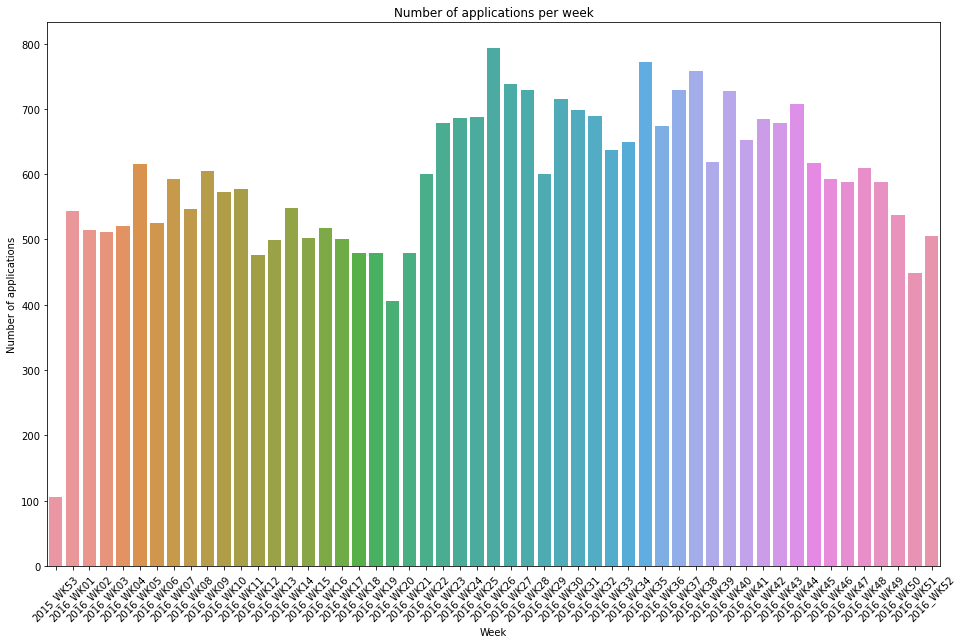

In [66]:
plt.figure(figsize=[16,10])
ax = sns.barplot(x=apps_created_per_week.index, y=apps_created_per_week.values)
ax.set(ylabel="Number of applications", xlabel = "Week")
ax.set_title("Number of applications per week")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

We can see that the weeks with the most new loan applications were the weeks 25, 34 and 37 of 2016. But the variation in the year 2016 was not very large.

## **Question 2: What is the total number of successful applications per week?**

In [67]:
apps_pending = df_temporal_exp[df_temporal_exp['concept:name'] == 'A_Pending']
apps_pending.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,datetime,week
38,statechange,User_115,A_Pending,Application,ApplState_1179730815,complete,2016-01-14 15:49:11.420000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-14 15:49:11.420000+00:00,2016_WK02
114,statechange,User_90,A_Pending,Application,ApplState_16917315,complete,2016-01-14 07:00:14.450000+00:00,Home improvement,New credit,Application_428409768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-14 07:00:14.450000+00:00,2016_WK02
197,statechange,User_95,A_Pending,Application,ApplState_1840619616,complete,2016-01-28 12:18:51.292000+00:00,Car,New credit,Application_1746793196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-28 12:18:51.292000+00:00,2016_WK04
363,statechange,User_119,A_Pending,Application,ApplState_1373444220,complete,2016-01-22 08:03:30.899000+00:00,Car,New credit,Application_619403287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-22 08:03:30.899000+00:00,2016_WK03
428,statechange,User_75,A_Pending,Application,ApplState_788894388,complete,2016-01-27 09:25:38.989000+00:00,"Other, see explanation",New credit,Application_1529124572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-27 09:25:38.989000+00:00,2016_WK04


In [68]:
pendings_per_week = apps_pending.groupby(['week'])['case:concept:name'].count()
pendings_per_week.sample(5)

week
2016_WK30    407
2016_WK13    262
2016_WK20    185
2016_WK31    262
2016_WK08    459
Name: case:concept:name, dtype: int64

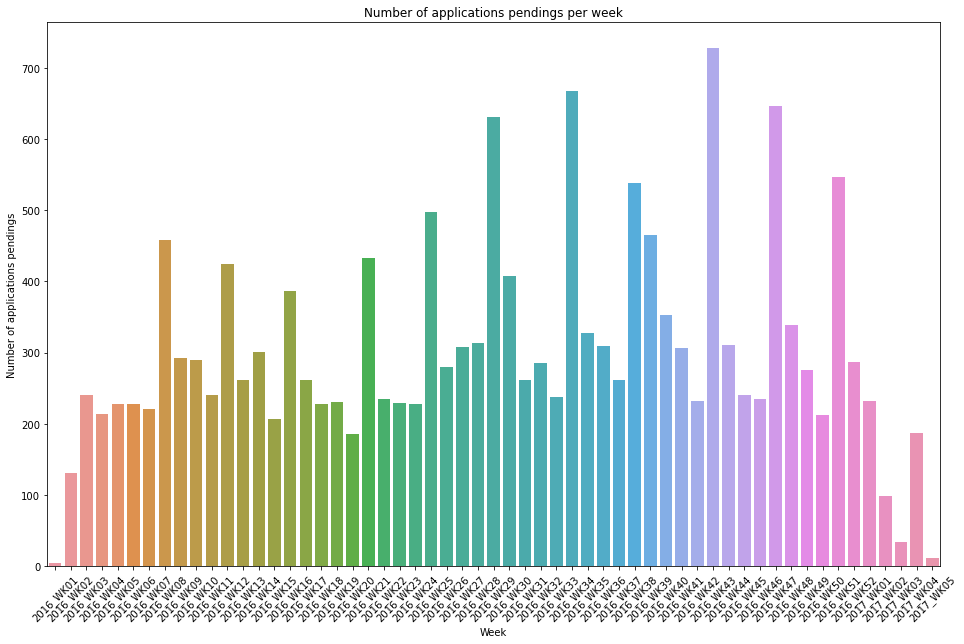

In [69]:
plt.figure(figsize=[16,10])
ax = sns.barplot(x=pendings_per_week.index, y=pendings_per_week.values)
ax.set(ylabel="Number of applications pendings", xlabel = "Week")
ax.set_title("Number of applications pendings per week")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

While the number of new applications per week did not vary much, the number of completed applications (A_Pending) had a greater variation. Week 42 of 2016 had the most applications successfully completed.


## **Question 3: Per week, what is the average number of events that occurred until the application was successfully completed?**

In [70]:
apps_name_pending = df_temporal_exp[df_temporal_exp['concept:name'] == 'A_Pending']['case:concept:name'].drop_duplicates()
events_apps_pending = df_temporal_exp.merge(apps_name_pending, on='case:concept:name')
events_apps_pending.sample(5)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,datetime,week
750246,Obtained,User_2,W_Complete application,Workflow,Workitem_1374551895,start,2016-12-14 10:15:43.209000+00:00,Car,Limit raise,Application_224662530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-14 10:15:43.209000+00:00,2016_WK50
88102,Created,User_74,O_Create Offer,Offer,Offer_407197014,complete,2016-03-15 18:55:03.138000+00:00,Remaining debt home,New credit,Application_1277679234,...,0.0,89.0,False,200.0,True,902.0,15000.0,NaN,2016-03-15 18:55:03.138000+00:00,2016_WK11
31274,Created,User_1,A_Create Application,Application,Application_1409118214,complete,2016-01-18 13:46:15.031000+00:00,Car,New credit,Application_1409118214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-18 13:46:15.031000+00:00,2016_WK03
351237,Released,User_126,W_Validate application,Workflow,Workitem_920643048,suspend,2016-07-07 09:28:01.393000+00:00,Unknown,New credit,Application_232898209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-07 09:28:01.393000+00:00,2016_WK27
11997,Obtained,User_12,W_Complete application,Workflow,Workitem_1011534535,start,2016-01-09 09:12:37.105000+00:00,"Other, see explanation",New credit,Application_1152306667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-09 09:12:37.105000+00:00,2016_WK01


In [71]:
mean_ev_apps_pending_per_week = (events_apps_pending.groupby(['week','case:concept:name'])['EventID'].count()
                                 .groupby(['week']).mean()
                                 .reset_index()
                                 .rename(index = str, columns = {'EventID': "Mean of events"}))
mean_ev_apps_pending_per_week.sample(5)

,week,Mean of events
8,2016_WK08,13.067325
29,2016_WK29,12.398635
36,2016_WK36,13.070401
40,2016_WK40,14.185882
7,2016_WK07,14.621735


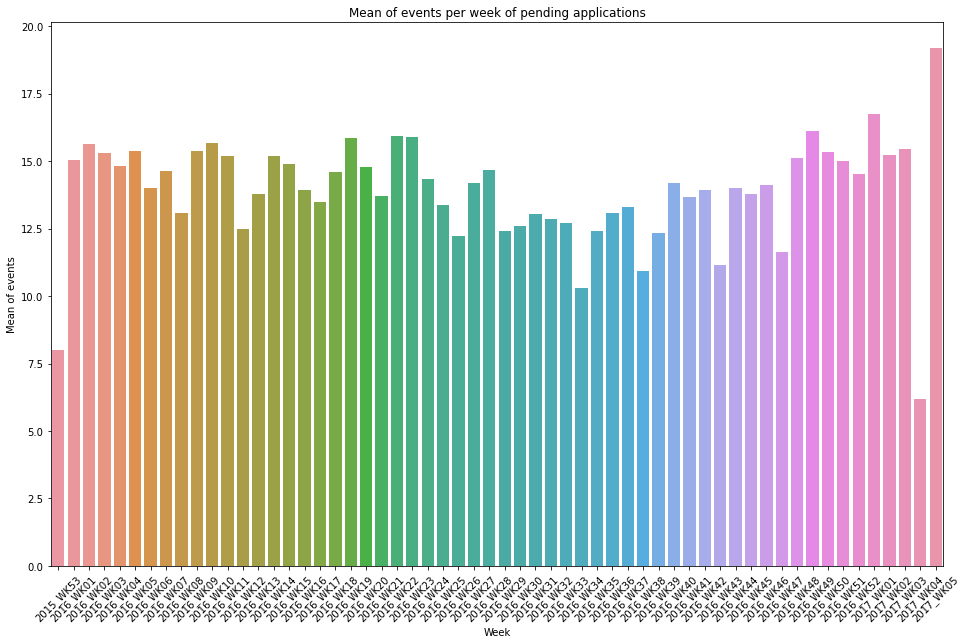

In [72]:
plt.figure(figsize=[16,10])
ax = sns.barplot(x='week', y='Mean of events', data=mean_ev_apps_pending_per_week)
ax.set(ylabel="Mean of events", xlabel = "Week")
ax.set_title("Mean of events per week of pending applications")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

The distribution did not vary much, some weeks had an average of lower logs, but many factors may have influenced, or the process was quick on the side of the company and the client, more applications finished successfully in the previous or next week, among others reasons.

 ## **Question 4: How long (in weeks) did each application last that was completed?**

In [73]:
apps_start_date = (df_temporal_exp[df_temporal_exp['concept:name'] == 'A_Create Application']
                    .filter(['case:concept:name','datetime'])
                    .rename(index=str, columns={'datetime' : 'start_date'}))

apps_end_date = (df_temporal_exp[df_temporal_exp['concept:name'].isin(['A_Cancelled', 'A_Denied', 'A_Pending'])]
                    .filter(['case:concept:name', 'datetime'])
                    .rename(index=str, columns={'datetime': 'end_date'}))
                    
apps_duration = pd.merge(apps_start_date, apps_end_date, how='inner', on='case:concept:name')
apps_duration['num_weeks'] = (apps_duration['end_date'] - apps_duration['start_date']).dt.days/7

apps_duration.filter(['case:concept:name', 'num_weeks']).sample(5)

,case:concept:name,num_weeks
9937,Application_956215142,3.857143
8633,Application_468766949,1.714286
3500,Application_1478562643,4.285714
27774,Application_64770427,2.142857
12653,Application_2083462775,1.000000


Para uma melhor visualização podemos analisar o número mínimo, máximo e médio de semanas. E também podemos visualizar num gráfico boxplot que consegue mostrar de forma mais claras estas métricas.

In [74]:
apps_duration['num_weeks'].describe().astype(int)

count    31412
mean         3
std          1
min          0
25%          1
50%          2
75%          4
max         24
Name: num_weeks, dtype: int64

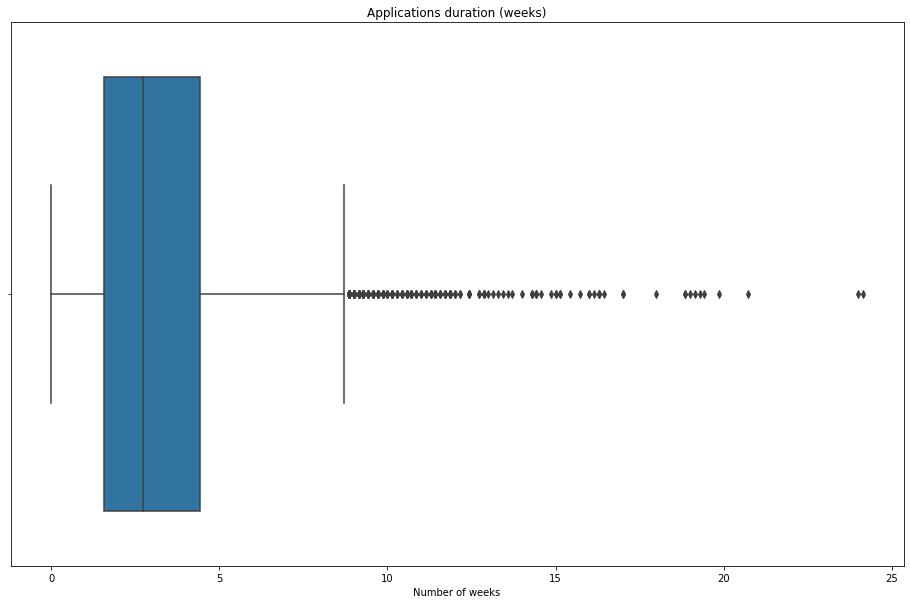

In [75]:
plt.figure(figsize=[16,10])
ax = sns.boxplot(x=apps_duration['num_weeks'])
ax.set_title('Applications duration (weeks)')
ax.set_xlabel('Number of weeks')
plt.show()

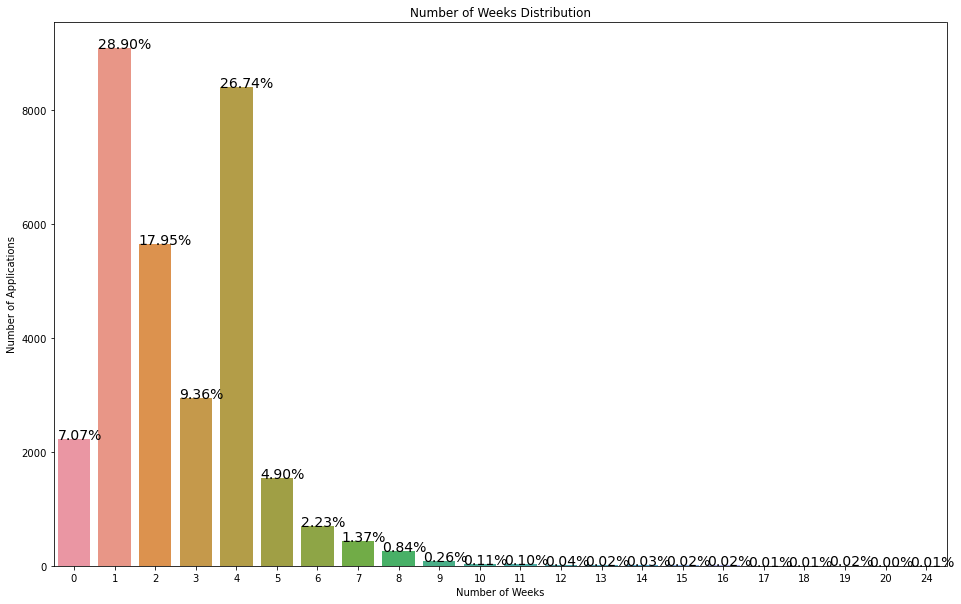

In [76]:
plt.figure(figsize=[16,10])
num_weeks = apps_duration['num_weeks'].astype(int)
ax = sns.countplot(num_weeks)
for p in ax.patches:
    (ax.annotate('{:.2f}%'.format(p.get_height()/len(num_weeks)*100), 
                 (p.get_x(), p.get_height()+1), fontsize=14))
ax.set_title("Number of Weeks Distribution")
ax.set(xlabel="Number of Weeks", ylabel="Number of Applications")
plt.show()

The bar graph shows the distribution of the number of weeks and the percentage that an application lasted until it completed successfully. A small percentage lasted for about 24 weeks (an average of 168 days), but most range from 1 to 4 weeks.

# **Classification**

## **Question 5: Will the application be finalized this week?**

To answer this question we have to predict something in the future and for this case we can use the Classification.

As the variable to be predicted is a future value, it indicates that it is a temporal variable, which is not a fixed target, as it will depend on temporal variables for it to happen, that is, it can vary in a timeline.

## **Selecting features**

The following input variables (features) were chosen:

* quarter: Current week year period of the application
* month: Current month of the application
* duration: Duration (in days) of application until the end of the previous week
* events_accum: Number of events until the end of the current week
* events_qty: Number of offers until the last day of the previous week
* offer_accum: Number of events until the end of the current week
* offer_qty: Number of offers for the application until the last day of the previous week

These features are temporal and need to be created.

## **Structuring the data**

Some columns will not be necessary for the model, so we can create a new data set with just the columns that we will need to create the features.

In [77]:
df_temporal = df_temporal_exp[['datetime', 'case:concept:name', 'concept:name', 'EventID']].copy(deep=True)
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571


Creating the column *start_week* that will keep the date of Monday, representing the current week.

In [78]:
df_temporal['start_week'] = (df_temporal['datetime']
                             .apply(lambda x : x - timedelta(x.dayofweek))
                             .dt.strftime('%d-%m-%Y'))
df_temporal['start_week'] = df_temporal['start_week'].apply(lambda x : datetime.strptime(x, '%d-%m-%Y'))
df_temporal.sample(2)

,datetime,case:concept:name,concept:name,EventID,start_week
656412,2016-07-28 13:25:20.612000+00:00,Application_941774290,W_Complete application,Workitem_901486078,2016-07-25
1070806,2016-11-21 10:14:26.171000+00:00,Application_235841717,W_Complete application,Workitem_419676093,2016-11-21


**Creating the feature 'quarter' - Current week year period of the application**

In [79]:
df_temporal['quarter'] = df_temporal['datetime'].dt.quarter
                            #.apply(lambda x: '1º Quarter' if x == 1 
                               #else ('2º Quarter' if x == 2 
                                     #else ('3º Quarter' if x == 3 
                                           #else '4º Quarter'))))
df_temporal.sample(5)

,datetime,case:concept:name,concept:name,EventID,start_week,quarter
285285,2016-04-07 13:18:14.791000+00:00,Application_2070124537,W_Complete application,Workitem_416281426,2016-04-04,2
27064,2016-01-12 18:36:13.295000+00:00,Application_1829687885,W_Call after offers,Workitem_819004786,2016-01-11,1
872042,2016-10-05 08:11:06.220000+00:00,Application_1148233536,W_Call incomplete files,Workitem_2080743272,2016-10-03,4
649869,2016-08-05 13:10:50.751000+00:00,Application_1440542670,O_Create Offer,Offer_47073104,2016-08-01,3
406055,2016-05-19 18:04:18.887000+00:00,Application_1139959523,W_Complete application,Workitem_477282936,2016-05-16,2


**Creating the feature 'month'- Current month  of the application**

In [80]:
df_temporal['month'] =  df_temporal['datetime'].dt.month
df_temporal.sample(5)

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month
563155,2016-07-06 09:19:24.538000+00:00,Application_763971035,W_Complete application,Workitem_1437063128,2016-07-04,3,7
512518,2016-06-20 10:13:04.743000+00:00,Application_2125168706,A_Concept,ApplState_412141042,2016-06-20,2,6
401105,2016-06-30 05:03:53.530000+00:00,Application_806535408,W_Validate application,Workitem_926226654,2016-06-27,2,6
1130634,2016-12-15 08:47:13.743000+00:00,Application_476454760,W_Validate application,Workitem_200984905,2016-12-12,4,12
1018048,2016-11-03 19:59:05.271000+00:00,Application_299626708,O_Create Offer,Offer_1353601523,2016-10-31,4,11


**Creating the feature 'duration' - Duration (in days) of application until the end of the previous week**

Creating application start and end date columns


In [81]:
apps_start_date = (df_temporal[df_temporal['concept:name'] == 'A_Create Application']
                    .filter(['case:concept:name','datetime'])
                    .rename(index=str, columns={'datetime' : 'creation_date'}))

df_temporal = df_temporal.merge(apps_start_date, on='case:concept:name', how='right')
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00


In [82]:
apps_final_date = (df_temporal[df_temporal['concept:name'].isin(['A_Denied', 'A_Cancelled', 'A_Pending'])]
                    .filter(['case:concept:name','datetime'])
                    .rename(index=str, columns={'datetime' : 'completion_date'}))

df_temporal = df_temporal.merge(apps_final_date, on='case:concept:name', how='right')
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00,2016-01-14 15:49:11.420000+00:00
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00,2016-01-14 15:49:11.420000+00:00
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00,2016-01-14 15:49:11.420000+00:00
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00,2016-01-14 15:49:11.420000+00:00
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00,2016-01-14 15:49:11.420000+00:00


Converting to datetime format

In [83]:
df_temporal['creation_date'] = df_temporal['creation_date'].apply(lambda x : datetime.strptime(x.strftime('%d-%m-%Y'), '%d-%m-%Y'))
df_temporal['completion_date'] = df_temporal['completion_date'].apply(lambda x : datetime.strptime(x.strftime('%d-%m-%Y'), '%d-%m-%Y'))

df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01,2016-01-14
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01,2016-01-14
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01,2016-01-14
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01,2016-01-14


In [84]:
df_temporal['end_week_prev'] = df_temporal['start_week'].apply(lambda x : x - timedelta(1))
df_temporal['duration'] = ((df_temporal['end_week_prev'] - df_temporal['creation_date']).dt.days).apply(lambda x : 0 if x < 0 else x)
df_temporal.sample(5)

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration
826328,2016-09-13 10:14:42.047000+00:00,Application_184706424,W_Complete application,Workitem_1709445842,2016-09-12,3,9,2016-09-12,2016-10-10,2016-09-11,0
16827,2016-01-19 08:29:21.864000+00:00,Application_335096189,W_Call after offers,Workitem_779664476,2016-01-18,1,1,2016-01-07,2016-01-22,2016-01-17,10
64952,2016-01-27 17:44:04.356000+00:00,Application_2082160,O_Cancelled,OfferState_432069328,2016-01-25,1,1,2016-01-24,2016-01-27,2016-01-24,0
1006067,2016-11-28 14:26:25.805000+00:00,Application_1781623698,W_Call incomplete files,Workitem_996676580,2016-11-28,4,11,2016-10-31,2016-12-22,2016-11-27,27
1144027,2016-12-12 13:11:31.946000+00:00,Application_2129089731,W_Complete application,Workitem_1352086898,2016-12-12,4,12,2016-12-11,2016-12-20,2016-12-11,0


**Creating feature 'events_accum' - Number of events until the end of the current week**

In [85]:
ev_app_per_week = (df_temporal.groupby(['case:concept:name', 'start_week'])['EventID'].count()
                                .reset_index()
                                .rename(index = str, columns = {'EventID': "ev_by_week"}))

ev_app_per_week["events_accum"] = ev_app_per_week.groupby(['case:concept:name'])['ev_by_week'].cumsum() 

In [86]:
df_temporal = df_temporal.merge(ev_app_per_week, on=['case:concept:name', 'start_week'], how='inner')
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17


**Creating feature 'events_qty' - Number of application events until the last day of the previous week**

In [87]:
df_temporal['events_qty'] = df_temporal['events_accum'] - df_temporal['ev_by_week']
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum,events_qty
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0


**Crating feature 'offers_accum' - Number of events until the end of the current week**

In [88]:
apps_offer_qty = (df_temporal[df_temporal['concept:name'] == 'O_Create Offer']
    .groupby(['case:concept:name', 'start_week'])['EventID'].count()
    .reset_index()  
    .rename(index = str, columns = {'EventID': "offer_by_week"}))

apps_offer_qty["offers_accum"] = apps_offer_qty.groupby(['case:concept:name'])['offer_by_week'].cumsum() 
apps_offer_qty.head()

,case:concept:name,start_week,offer_by_week,offers_accum
0,Application_1000086665,2016-08-01,1,1
1,Application_1000158214,2016-06-06,1,1
2,Application_1000311556,2016-04-04,1,1
3,Application_1000334415,2016-09-12,1,1
4,Application_1000339879,2016-03-14,1,1


In [89]:
df_temporal = df_temporal.merge(apps_offer_qty, on=['case:concept:name', 'start_week'], how='outer')
df_temporal[:20]

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum,events_qty,offer_by_week,offers_accum
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
5,2016-01-01 09:52:36.413000+00:00,Application_652823628,A_Concept,ApplState_642383566,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
6,2016-01-02 10:45:22.429000+00:00,Application_652823628,W_Complete application,Workitem_1875340971,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
7,2016-01-02 10:49:28.816000+00:00,Application_652823628,W_Complete application,Workitem_1452291795,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
8,2016-01-02 11:23:04.299000+00:00,Application_652823628,A_Accepted,ApplState_99568828,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
9,2016-01-02 11:29:03.994000+00:00,Application_652823628,O_Create Offer,Offer_148581083,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0


**Creating feature offers_qty - Number of offers for the application until the last day of the previous week**

In [90]:
df_temporal['offers_qty'] = df_temporal['offers_accum'] - df_temporal['offer_by_week']
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum,events_qty,offer_by_week,offers_accum,offers_qty
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0,0.0
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0,0.0
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0,0.0
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0,0.0
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0,0.0


## **Checking and handling missing values**

In [91]:
df_temporal.isnull().sum().sort_values(ascending=False)

offers_qty           591504
offer_by_week        591504
offers_accum         591504
month                     0
case:concept:name         0
concept:name              0
EventID                   0
start_week                0
quarter                   0
completion_date           0
creation_date             0
end_week_prev             0
duration                  0
ev_by_week                0
events_accum              0
events_qty                0
datetime                  0
dtype: int64

There are several rows with empty offer columns, because not every week has values ​​for offers so it was not counted. We can fill in the missing values with 0.

In [92]:
df_temporal = df_temporal.fillna(0)

In [93]:
df_temporal.isnull().sum().sort_values(ascending=False)

offers_qty           0
creation_date        0
case:concept:name    0
concept:name         0
EventID              0
start_week           0
quarter              0
month                0
completion_date      0
offers_accum         0
end_week_prev        0
duration             0
ev_by_week           0
events_accum         0
events_qty           0
offer_by_week        0
datetime             0
dtype: int64

It is now possible to convert the *offer_accum* and *offer_qty* columns to integer.

In [94]:
df_temporal['offers_accum'] = df_temporal['offers_accum'].astype(int)
df_temporal['offers_qty'] = df_temporal['offers_qty'].astype(int)
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum,events_qty,offer_by_week,offers_accum,offers_qty
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1,0
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1,0
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1,0
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1,0
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1,0


**Creating Target - Will the application be completed by the end of the week?**

Creating column with end date of the current week of the application

In [95]:
df_temporal['end_week'] = (df_temporal['start_week']
                           .apply(lambda x : x + timedelta(6)))
df_temporal.sample(2)

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum,events_qty,offer_by_week,offers_accum,offers_qty,end_week
1043609,2016-11-10 07:49:19.286000+00:00,Application_2067204767,A_Create Application,Application_2067204767,2016-11-07,4,11,2016-11-10,2016-11-25,2016-11-06,0,30,30,0,1.0,1,0,2016-11-13
46615,2016-01-19 11:27:55.568000+00:00,Application_1645963200,O_Sent (mail and online),OfferState_1854076793,2016-01-18,1,1,2016-01-18,2016-01-25,2016-01-17,0,23,23,0,1.0,1,0,2016-01-24


In [96]:
df_temporal['label'] = df_temporal['completion_date'] <= df_temporal['end_week']
df_temporal.sample(10)

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum,events_qty,offer_by_week,offers_accum,offers_qty,end_week,label
623301,2016-07-22 14:37:12.994000+00:00,Application_1566847946,W_Call after offers,Workitem_2137348819,2016-07-18,3,7,2016-07-17,2016-08-18,2016-07-17,0,14,20,6,1.0,1,0,2016-07-24,False
577355,2016-07-21 06:50:33.942000+00:00,Application_867065139,W_Validate application,Workitem_294940406,2016-07-18,3,7,2016-07-05,2016-07-29,2016-07-17,12,23,44,21,1.0,2,1,2016-07-24,False
180947,2016-03-01 20:02:58.380000+00:00,Application_1013582921,O_Create Offer,Offer_628126114,2016-02-29,1,3,2016-03-01,2016-03-14,2016-02-28,0,26,26,0,2.0,2,0,2016-03-06,False
4502,2016-01-29 14:22:26.457000+00:00,Application_774787486,O_Refused,OfferState_1927000500,2016-01-25,1,1,2016-01-04,2016-01-29,2016-01-24,20,14,33,19,1.0,2,1,2016-01-31,True
837821,2016-09-14 16:49:55.543000+00:00,Application_59647812,W_Call after offers,Workitem_200816329,2016-09-12,3,9,2016-09-14,2016-10-15,2016-09-11,0,13,13,0,1.0,1,0,2016-09-18,False
424723,2016-05-27 08:28:01.483000+00:00,Application_769436216,W_Call after offers,Workitem_1143754758,2016-05-23,2,5,2016-05-26,2016-06-27,2016-05-22,0,17,17,0,1.0,1,0,2016-05-29,False
1115638,2016-12-02 10:06:26.388000+00:00,Application_1685601249,A_Concept,ApplState_1976095315,2016-11-28,4,12,2016-12-02,2016-12-22,2016-11-27,0,8,8,0,0.0,0,0,2016-12-04,False
925225,2016-10-10 15:04:37.540000+00:00,Application_1009860656,W_Call after offers,Workitem_1387338808,2016-10-10,4,10,2016-10-08,2016-10-17,2016-10-09,1,16,22,6,1.0,1,0,2016-10-16,False
600545,2016-07-25 07:42:05.887000+00:00,Application_1745871797,W_Call after offers,Workitem_452606608,2016-07-25,3,7,2016-07-11,2016-07-28,2016-07-24,13,11,32,21,0.0,0,0,2016-07-31,True
325845,2016-04-20 12:40:53.716000+00:00,Application_423652896,O_Sent (mail and online),OfferState_1481995658,2016-04-18,2,4,2016-04-20,2016-05-21,2016-04-17,0,14,14,0,1.0,1,0,2016-04-24,False


Removing useless columns for the next steps

In [97]:
df_temporal = df_temporal.drop(['concept:name', 'datetime', 'EventID', 'ev_by_week', 'offer_by_week'], axis=1)
df_temporal

,case:concept:name,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,events_accum,events_qty,offers_accum,offers_qty,end_week,label
0,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,0,1,0,2016-01-03,False
1,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,0,1,0,2016-01-03,False
2,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,0,1,0,2016-01-03,False
3,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,0,1,0,2016-01-03,False
4,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,0,1,0,2016-01-03,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198397,Application_1350494635,2017-01-02,1,1,2016-12-31,2017-01-16,2017-01-01,1,18,6,1,0,2017-01-08,False
1198398,Application_1350494635,2017-01-02,1,1,2016-12-31,2017-01-16,2017-01-01,1,18,6,1,0,2017-01-08,False
1198399,Application_1350494635,2017-01-16,1,1,2016-12-31,2017-01-16,2017-01-15,15,21,18,0,0,2017-01-22,True
1198400,Application_1350494635,2017-01-16,1,1,2016-12-31,2017-01-16,2017-01-15,15,21,18,0,0,2017-01-22,True


Removing duplicate lines. Note: All applications have several logs per week, due to the new dataset some lines have become duplicated and need to be removed.

In [98]:
df_temporal = df_temporal.drop_duplicates()
df_temporal[:30]

,case:concept:name,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,events_accum,events_qty,offers_accum,offers_qty,end_week,label
0,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,0,1,0,2016-01-03,False
17,Application_652823628,2016-01-04,1,1,2016-01-01,2016-01-14,2016-01-03,2,19,17,0,0,2016-01-10,False
19,Application_652823628,2016-01-11,1,1,2016-01-01,2016-01-14,2016-01-10,9,40,19,0,0,2016-01-17,True
40,Application_1691306052,2015-12-28,1,1,2016-01-01,2016-01-07,2015-12-27,0,18,0,1,0,2016-01-03,False
58,Application_1691306052,2016-01-04,1,1,2016-01-01,2016-01-07,2016-01-03,2,31,18,0,0,2016-01-10,True
71,Application_428409768,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,20,0,2,0,2016-01-03,False
91,Application_428409768,2016-01-04,1,1,2016-01-01,2016-01-14,2016-01-03,2,22,20,0,0,2016-01-10,False
93,Application_428409768,2016-01-11,1,1,2016-01-01,2016-01-14,2016-01-10,9,45,22,0,0,2016-01-17,True
116,Application_1746793196,2015-12-28,1,1,2016-01-01,2016-01-28,2015-12-27,0,11,0,0,0,2016-01-03,False
127,Application_1746793196,2016-01-04,1,1,2016-01-01,2016-01-28,2016-01-03,2,32,11,2,0,2016-01-10,False


Viewing the distribution of classes

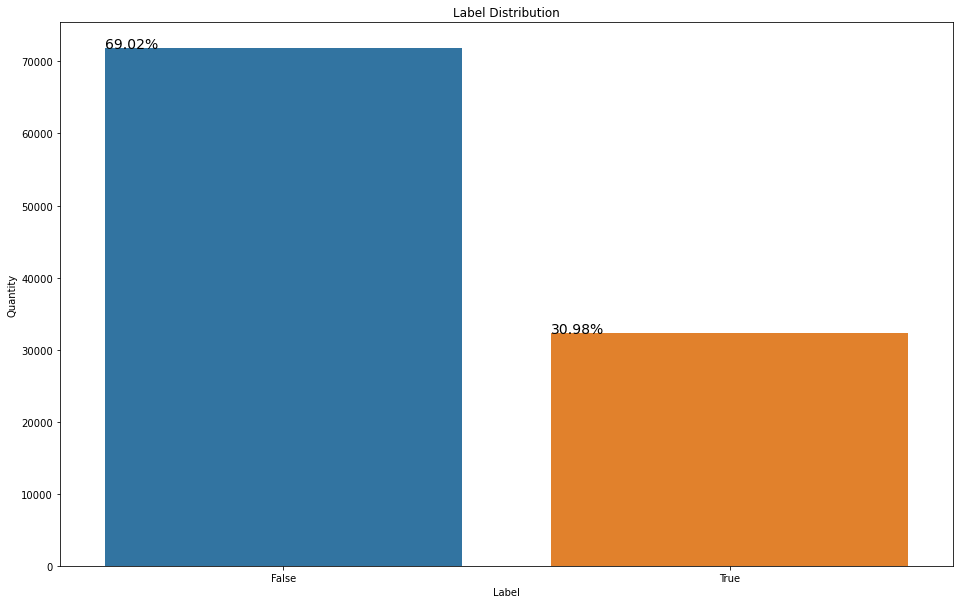

In [99]:
plt.figure(figsize=[16,10])
labels_occ = df_temporal['label']
ax = sns.barplot(x=labels_occ.value_counts().index, y=labels_occ.value_counts(), orient='v')
for p in ax.patches:
    (ax.annotate('{:.2f}%'.format(p.get_height()/len(labels_occ)*100), 
                 (p.get_x(), p.get_height()+1), fontsize=14))
ax.set(xlabel="Label", ylabel = "Quantity")
ax.set_title("Label Distribution")
plt.show()

## **Extracting the data**

In [100]:
df_model = df_temporal[['case:concept:name', 'events_accum', 'events_qty', 'offers_accum', 'offers_qty', 'label']]

I used the *sklearn* library's *train_test_split* function to separate the data for training and testing. Usually 30% of the data is an ideal size for the test set and this is passed as a function parameter. 

**Note: Training set applications do not appear in the test set and vice versa**

In [101]:
x_train, x_test = train_test_split(df_model['case:concept:name'].drop_duplicates(), test_size=0.3)
x_train = df_model.merge(x_train, on="case:concept:name")
x_test = df_model.merge(x_test, on="case:concept:name")

y_test = x_test['label']
y_train = x_train['label']
x_train = x_train.drop(['case:concept:name', 'label'], axis=1)
x_test = x_test.drop(['case:concept:name', 'label'], axis=1)

## **Building a Model**

To find the model, we used Sklearn's pipeline and GridSearch to find the best classifier and parameters.

The classifiers used were:

* LogisticRegression
* KNeighborsClassifier
* DecisionTreeClassifier
* RandomForestClassifier
* GaussianNB

In [102]:
pipe = Pipeline([
   ('scaler', StandardScaler()),
   ('classifier', LogisticRegression())
])

List with some parameters chosen for each classifier. Where the best parameters will be chosen and the best classifier.

In [103]:
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 4, 20)},
    {'classifier' : [KNeighborsClassifier()],
     'classifier__leaf_size' : [1,5,10,30],
     'classifier__n_neighbors' : [2,5,10,20], 
     'classifier__p' : [1,2]},
    {'classifier' : [DecisionTreeClassifier(random_state=199)],
     'classifier__max_depth' : [10, 50, 100],
     'classifier__min_samples_split' : [1, 5, 10]},
    {'classifier' : [RandomForestClassifier(random_state=199)],
     'classifier__n_estimators' : [10,50,250],
     'classifier__max_depth' : [10, 50, 100],
     'classifier__min_samples_split' : [1, 5, 10]},
    {'classifier' : [GaussianNB()]}
]

Creating classifier using GridSearchCV and estimator and parameters that were previously defined.

In [104]:
clf_gs = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1)

Performing the training using the fit function

In [105]:
clf_gs.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+0...
                         {'classifier': [DecisionTreeClassifier(random_state=199)],
                          'classifier__max_depth': [10, 50, 100],
                          'classifier__min_samples_split': [1, 5, 10]},
                         {'classifier': [RandomForestClassifier(max_depth=50,
                                                                min_samples_split=10,
                                                                n_estimators=250,
                                                       

Printing the best parameters and the best score.

In [113]:
print("Best params (CV score=%0.5f):" % clf_gs.best_score_)
print(clf_gs.best_params_)

Best params (CV score=0.86997):
{'classifier': RandomForestClassifier(max_depth=50, min_samples_split=10, n_estimators=250,
                       random_state=199), 'classifier__max_depth': 50, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 250}


Performing the prediction with the best classifier found

In [112]:
y_pred = clf_gs.predict(x_test)

## **Evaluating the Model**

Since we already have a trained model and perform a prediction, we can evaluate the model using several metrics:

* **Accuracy**: It is the number of data correctly predicted in all data sets. It tells you how accurate the model is.
* **Recall**: It is the proportion of positive observations correctly predicted in relation to the total of predicted observations.
* **Precision**: It is the proportion of positive observations correctly predicted in relation to the total of positive predicted observations. It's how accurate the model is.

In [115]:
accuracy = metrics.accuracy_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("f1-Score: ", f1)

Accuracy:  0.8740766908600424
Recall:  0.8193421189166753
Precision:  0.7836443032949583
f1-Score:  0.8010957236341499


For a better visualization of the prediction results of each class, we can create a confusion matrix. Confusion matrix is precisely a table that shows the frequency of classification for each class of the model.

In the confusion matrix:

* First quadrant is the *true positive* (TP): it occurs when in the real set, the class that is to be predicted was correctly predicted.
* Second quadrant is the *false positive* (FP): it occurs when in the real set, the class to be predicted was predicted incorrectly.
* Third quadrant is the *false negative* (FN): it occurs when in the real set, the class that is not intended to be predicted was incorrectly predicted.
* Fourth quadrant is the *true negative* (TN): it occurs when in the real set, the class that is not wanted to be predicted that was correctly predicted.

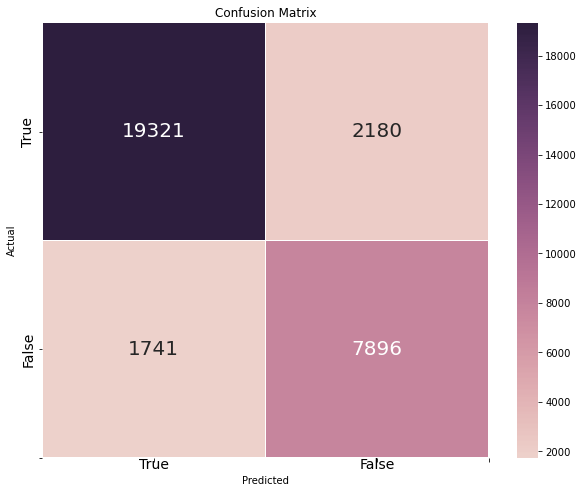

In [116]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

## **Checking feature importances**

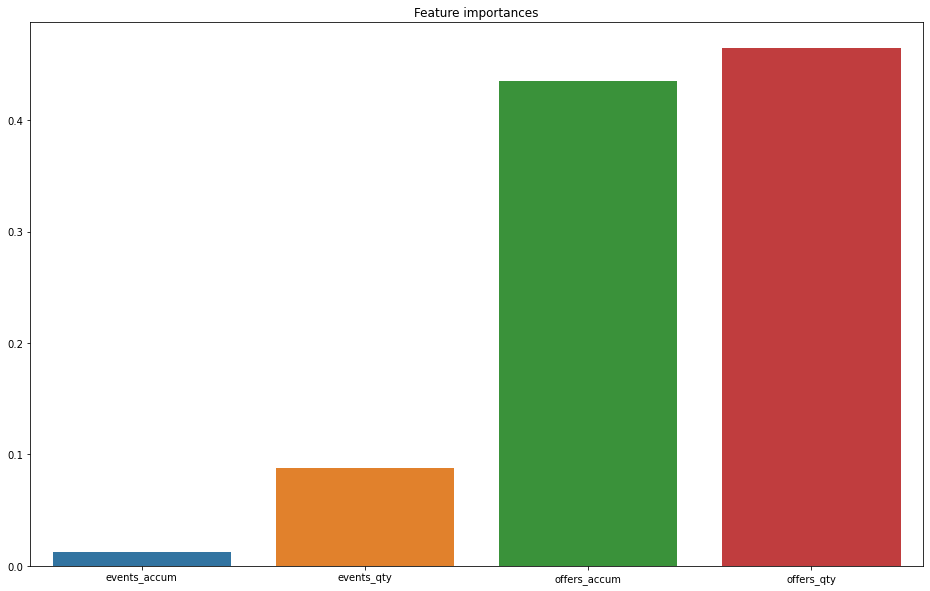

In [117]:
features = x_train.columns

features_importances = pd.Series(clf_gs.best_estimator_.named_steps["classifier"].feature_importances_, index=features)

plt.figure(figsize=[16,10])
ax = sns.barplot(x=features_importances.values, y=features_importances)
ax.set_title("Feature importances")
plt.xticks(list(range(len(features_importances))), features)
plt.show()

# **Conclusions**

In this notebook we explore the data made available by BPI Challenge 2017 in order to practice knowledge of data analysis, exploratory data analysis, machine learning, among others, especially temporal data.

We analyze some data per week, amount of application, average of events per application and among others.

We tested some classifiers to predict whether an application would be completed in the current week.
The best classifier was Random Forest with an accuracy of 87%. To achieve this result, some bulletin features have been removed from the model.

For better results in the classification we can improve the balance of the data, improve the division of the training and test sets, improve the features, test new classifiers or parameters, among others.

The analyzes were carried out during studies to practice the knowledge of the acquired area, for more interpretations and decisions, more in-depth analyzes should be carried out.
For the main purpose of the notebook, the result was satisfactory.